#AIRBNB Price Prediction Using Pyspark



The purpose of this project is to explore the data using pyspark and predict the price of an Airbnb listing from features extracted from the listings using SparkML.


**Data Source**
https://www.kaggle.com/datasets/stevezhenghp/airbnb-price-prediction

Data Variable Details:

id	 - 	ID of the AirBNB

log_price	 - 	Price of the AIRBNB

property_type	 - 	Apartment/house/Villa

room_type	 - 	Entire house/sharing/Single Room

amenities	 - 	TV/Wifi etc

accommodates	 - 	Number of members Airbnb could accommodate

bathrooms	 - 	Number of bathrooms

bed_type	 - 	Read bed/couch/airbed

cancellation_policy	 - 	Stric/Flexible

cleaning_fee	 - 	True/False

city	 - 	City

description	 - 	Description

first_review	 - 	Date

host_has_profile_pic	 - 	True/False

host_identity_verified	 - 	True/False

host_response_rate	 - 	Percentage

host_since	 - 	Date

instant_bookable	 - 	True/False

last_review	 - 	Date

latitude	 - 	Latitude

longitude	 - 	Longitude

name	 - 	Name of the Airbnb

neighbourhood	 - 	Neighbourhood of the Airbnb

number_of_reviews	 - 	Number_Of_Reviews of the Airbnb

review_scores_rating	 - 	Review_Scores_Rating of the Airbnb

thumbnail_url	 - 	Thumbnail_Url of the Airbnb

zipcode	 - 	Zipcode of the Airbnb

bedrooms	 - 	Number of Bedrooms

beds	 - 	Number of beds



In [1]:
!pip install pyspark

Importing the required libraries

In [2]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
from pyspark.sql.types import *
from pyspark.sql.functions import *
import plotly as py
import pandas as pd
import numpy as np
from pyspark.sql import SQLContext
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt
sc = spark.sparkContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import OneHotEncoder


In [3]:
from pyspark.ml.regression import LinearRegression

Reading the CSV file
Used quote and escape option as amenities column contains comma in the data

In [4]:
df = spark.read.option("delimiter",",").option("quote",'\"').option("escape",'\"').option("header",True).option("inferSchema",True).csv('train.csv')

Displaying first 5 rows of the dataframe

In [5]:
df.show(5)

+--------+------------------+-------------+---------------+--------------------+------------+---------+--------+-------------------+------------+----+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+------------------+-------------------+--------------------+----------------+-----------------+--------------------+--------------------+-------+--------+----+
|      id|         log_price|property_type|      room_type|           amenities|accommodates|bathrooms|bed_type|cancellation_policy|cleaning_fee|city|         description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|          latitude|          longitude|                name|   neighbourhood|number_of_reviews|review_scores_rating|       thumbnail_url|zipcode|bedrooms|beds|
+--------+------------------+-------------+---------------+--------------------+------------+---------+---

In [6]:
df.show(n=1,truncate=False,vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id                     | 6901257                                                                                                                                                                                                             
 log_price              | 5.010635294096256                                                                                                                                                                                                   
 property_type          | Apartment                                                                                                                                                                                                           
 room_type              | Entire home/apt   

Displaying schema of the Dataframe

In [7]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- log_price: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- amenities: string (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- cleaning_fee: boolean (nullable = true)
 |-- city: string (nullable = true)
 |-- description: string (nullable = true)
 |-- first_review: string (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- host_response_rate: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- neighbourhood: string (nullable = tru

In [8]:
print("Number of rows in the dataframe",df.count())

Number of rows in the dataframe 74113


In [9]:
print("Number of columns in the dataframe",len(df.columns))

Number of columns in the dataframe 29


Checking for the null values in the dataframe

In [10]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+---+---------+-------------+---------+---------+------------+---------+--------+-------------------+------------+----+-----------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+--------+---------+----+-------------+-----------------+--------------------+-------------+-------+--------+----+
| id|log_price|property_type|room_type|amenities|accommodates|bathrooms|bed_type|cancellation_policy|cleaning_fee|city|description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|latitude|longitude|name|neighbourhood|number_of_reviews|review_scores_rating|thumbnail_url|zipcode|bedrooms|beds|
+---+---------+-------------+---------+---------+------------+---------+--------+-------------------+------------+----+-----------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+--------+---------+----+-------

Dataframe consists of null values, hence dropping them

In [11]:
df = df.na.drop()

Checking for null values after the cleanup

In [12]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+---+---------+-------------+---------+---------+------------+---------+--------+-------------------+------------+----+-----------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+--------+---------+----+-------------+-----------------+--------------------+-------------+-------+--------+----+
| id|log_price|property_type|room_type|amenities|accommodates|bathrooms|bed_type|cancellation_policy|cleaning_fee|city|description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|latitude|longitude|name|neighbourhood|number_of_reviews|review_scores_rating|thumbnail_url|zipcode|bedrooms|beds|
+---+---------+-------------+---------+---------+------------+---------+--------+-------------------+------------+----+-----------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+--------+---------+----+-------

The dataframe is clean and good for processing

In [13]:
df1 = df.toPandas()

In [14]:
df1['exp_price'] = np.exp(df1['log_price'])

In [15]:
df1.head(5)

id  log_price property_type        room_type  \
0   6304928   5.129899     Apartment  Entire home/apt   
1   7919400   4.976734     Apartment  Entire home/apt   
2  12422935   4.442651     Apartment     Private room   
3  13971273   4.787492   Condominium  Entire home/apt   
4    180792   4.787492         House     Private room   

                                           amenities  accommodates  bathrooms  \
0  {"Wireless Internet","Air conditioning",Kitche...             7        1.0   
1  {TV,"Cable TV","Wireless Internet","Air condit...             5        1.0   
2  {TV,"Wireless Internet",Heating,"Smoke detecto...             2        1.0   
3  {TV,"Cable TV","Wireless Internet","Wheelchair...             2        1.0   
4  {TV,"Cable TV","Wireless Internet","Pets live ...             2        1.0   

   bed_type cancellation_policy  cleaning_fee  ...   longitude  \
0  Real Bed              strict          True  ...  -73.989040   
1  Real Bed            moderate          True  ...  -73.943756   
2  Real Bed              strict          True  ... -122.429526   
3  Real Bed            moderate          True  ... -118.260439   
4  Real Bed            moderate          True  ... -122.501095   

                                                name      neighbourhood  \
0           Superb 3BR Apt Located Near Times Square     Hell's Kitchen   
1                                   The Garden Oasis             Harlem   
2                        Comfort Suite San Francisco         Noe Valley   
3  Near LA Live, Staple's. Starbucks inside. OWN ...           Downtown   
4                 Cozy Garden Studio - Private Entry  Richmond District   

  number_of_reviews review_scores_rating  \
0                 6                 93.0   
1                10                 92.0   
2                 3                100.0   
3                 9                 93.0   
4               159                 99.0   

                                       thumbnail_url zipcode bedrooms beds  \
0  https://a0.muscache.com/im/pictures/348a55fe-4...   10019      3.0  3.0   
1  https://a0.muscache.com/im/pictures/6fae5362-9...   10027      1.0  3.0   
2  https://a0.muscache.com/im/pictures/82509143-4...   94131      1.0  1.0   
3  https://a0.muscache.com/im/pictures/61bd05d5-c...   90015      1.0  1.0   
4  https://a0.muscache.com/im/pictures/0ed6c128-7...   94121      1.0  1.0   

   exp_price  
0      169.0  
1      145.0  
2       85.0  
3      120.0  
4      120.0  

[5 rows x 30 columns]

Checking which property types are present in Airbnb?

In [16]:
df.createOrReplaceTempView('price')

query = """
SELECT property_type,count(id) as Total_count
FROM price
group by property_type 
order by Total_count desc

"""
print("Total count based on property type")
spark.sql(query).show()

Total count based on property type
+------------------+-----------+
|     property_type|Total_count|
+------------------+-----------+
|         Apartment|      24750|
|             House|       8903|
|       Condominium|       1421|
|         Townhouse|        940|
|              Loft|        719|
|        Guesthouse|        335|
|             Other|        331|
|   Bed & Breakfast|        286|
|          Bungalow|        216|
|       Guest suite|         97|
|              Dorm|         90|
|             Villa|         68|
|            In-law|         61|
|            Hostel|         46|
|             Cabin|         45|
|         Camper/RV|         35|
|              Boat|         35|
|    Boutique hotel|         32|
|         Timeshare|         30|
|Serviced apartment|         12|
+------------------+-----------+
only showing top 20 rows



The biggest number of property categories on Airbnb is apartments.

Rating of the Airbnb depends on the cancellation policy

In [17]:
df.createOrReplaceTempView('cancellation')

query = """
SELECT cancellation_policy,count(cancellation_policy),sum(review_scores_rating)/count(review_scores_rating) as avg_rating
FROM cancellation
group by cancellation_policy
order by avg_rating desc

"""
print("Cancellation policy")
spark.sql(query).show()

Cancellation policy
+-------------------+--------------------------+-----------------+
|cancellation_policy|count(cancellation_policy)|       avg_rating|
+-------------------+--------------------------+-----------------+
|           moderate|                     11386|95.08598278587739|
|           flexible|                      7342|94.55107600108963|
|             strict|                     19733|93.82673693812396|
|    super_strict_30|                        33|89.33333333333333|
|    super_strict_60|                         6|85.66666666666667|
+-------------------+--------------------------+-----------------+



It could be infered that there is no correlation between the cancellation policy and average rating of the airbnb

Checking the price of Air bnb across each neighbourhood

In [18]:
table = pd.pivot_table(df1,values='log_price',columns = ['neighbourhood'],aggfunc='sum',fill_value=0)

In [19]:
table

neighbourhood  16th Street Heights  Adams Morgan  Alamo Square  Albany Park  \
log_price               234.978761    421.047795    289.553854    59.433423   

neighbourhood    Alhambra   Allerton  Allston-Brighton  Alphabet City  \
log_price      253.767386  39.720371       1202.491899    1655.165482   

neighbourhood    Altadena  American University Park  ...  Windsor Terrace  \
log_price      354.089978                 65.373414  ...       286.264427   

neighbourhood   Winnetka  Woodhaven  Woodland  Woodland Hills/Warner Center  \
log_price      68.838737  85.683407  4.828314                    376.925498   

neighbourhood    Woodlawn  Woodley Park  Woodridge    Woodside  Wrigleyville  
log_price      102.059091    115.851425  53.212886  232.344113    134.555531  

[1 rows x 586 columns]

In [20]:
df.createOrReplaceTempView('neighbourhood')

query = """
SELECT neighbourhood,sum(log_price) as sum_price
FROM neighbourhood
group by neighbourhood
order by sum_price desc

"""
print("Neighbourhood price")
spark.sql(query).show()

Neighbourhood price
+------------------+------------------+
|     neighbourhood|         sum_price|
+------------------+------------------+
|      Williamsburg|7275.7173164465385|
|Bedford-Stuyvesant| 5982.271001565974|
|    Hell's Kitchen| 4140.316933646376|
|      Mid-Wilshire|3916.2164838808944|
|            Harlem| 3770.043012084726|
|          Bushwick| 3740.662262426323|
|         Hollywood|3549.5390725684742|
|   Upper West Side| 3323.719343543865|
|            Venice|3285.1293164910685|
|   Upper East Side|3244.2471536107323|
|     Crown Heights| 2674.175813688198|
|  Mission District|2298.4790241763517|
|   Lower East Side|  2283.01199060224|
|       East Harlem| 2259.493500459149|
|           Astoria|2165.7209787580837|
|      East Village|2148.7046679127197|
|           Chelsea|1972.5467435952937|
|    West Hollywood|1870.5026168224595|
|        Long Beach|1726.6779188956689|
|      West Village| 1707.926392322313|
+------------------+------------------+
only showing top 20 

Williamsburg neighborhood has the higest average price when compared to others

### What are the most common types of rooms on Airbnb?

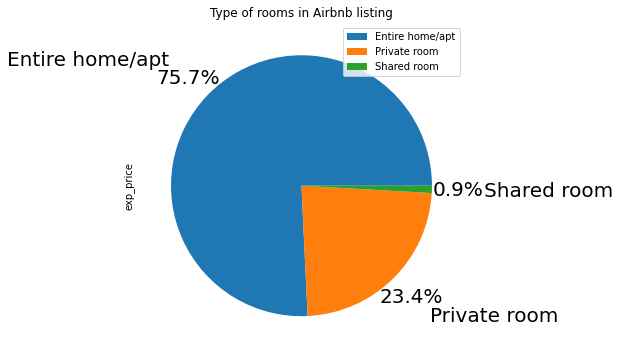

In [21]:
df1.groupby(['room_type']).sum().plot(kind='pie',y= 'exp_price',radius = 1,title=
 "Type of rooms in Airbnb listing",autopct='%1.1f%%',fontsize=20,figsize=(6, 6),pctdistance=1.2,labeldistance=1.4)

Most of the Airbnb's are enitire homes/apt

### Does the price depends on the Review scores rating

In [22]:
df_grp = df1.groupby(['review_scores_rating'])['exp_price'].sum().reset_index()
df_grp.head()

review_scores_rating  exp_price
0                  20.0     8006.0
1                  27.0       58.0
2                  35.0      102.0
3                  40.0     4411.0
4                  47.0     1122.0

In [23]:
df_grp.tail()

review_scores_rating  exp_price
47                  96.0   447143.0
48                  97.0   460707.0
49                  98.0   499551.0
50                  99.0   332687.0
51                 100.0  1494133.0

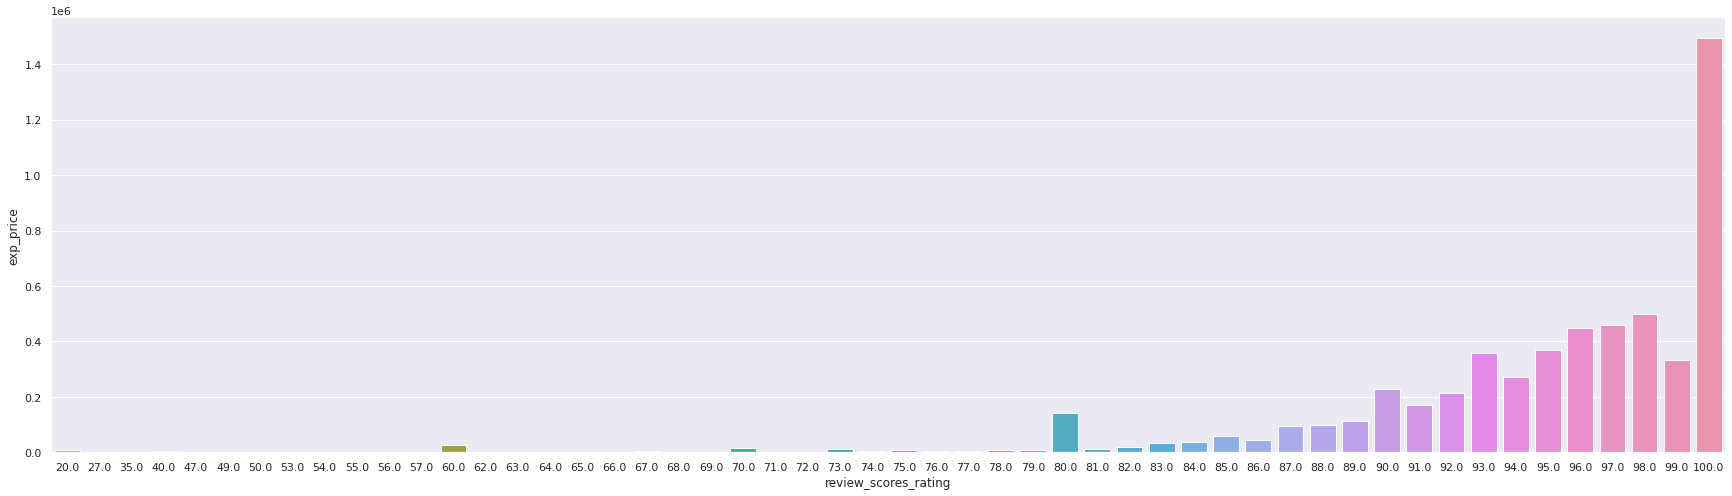

In [24]:
sns.set(rc = {'figure.figsize':(30,8)})
sns.barplot(x='review_scores_rating', y='exp_price', data=df_grp);


In [25]:
df_grp = df1.groupby(['review_scores_rating'])['exp_price'].count().reset_index()


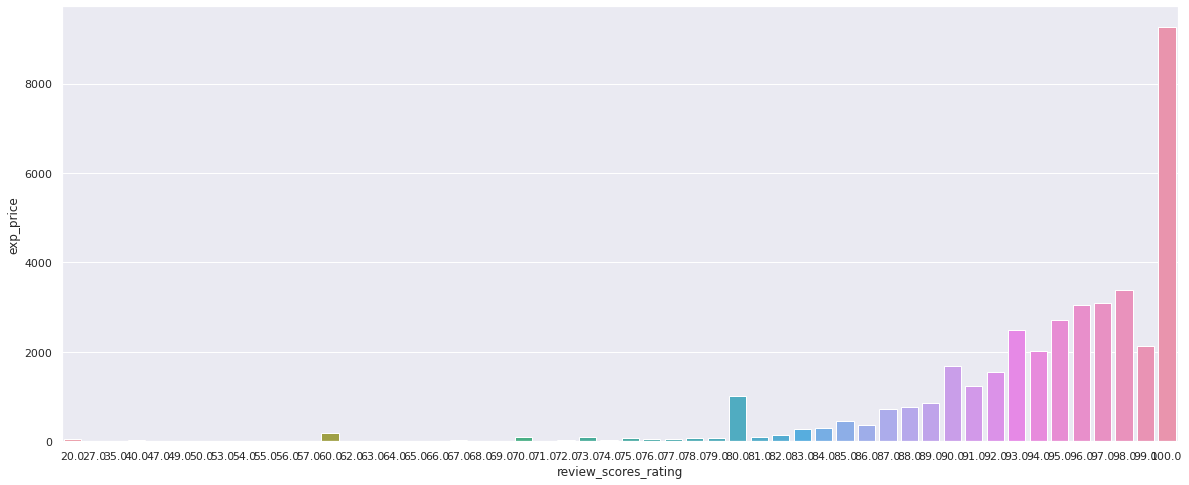

In [26]:
plt.figure(figsize = (20,8))
sns.barplot(x='review_scores_rating', y='exp_price', data=df_grp);

From the above plots and the values obtained, it could be infered that the  Airbnbs with good rating have high price when compared to the others

### Plotting the position of the Airbnbs on the Map

In [27]:
fig = px.scatter_mapbox(df1,lat="latitude",lon="longitude",hover_data=['name'],color='exp_price',zoom=10)
fig.update_layout(
            title = f'Airbnb prices in ',geo_scope='usa',width=1000, height=600,mapbox_style="white-bg",
            mapbox_layers=[{
                 "below": 'traces',"sourcetype": "raster","sourceattribution": "United States Geological Survey",
                 "source": ["https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"]
              }]
    )
fig.show()
    

### Which city has more Airbnb's?

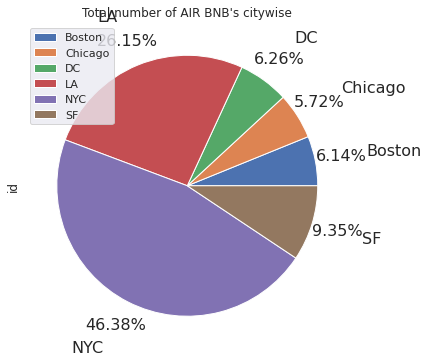

In [28]:
df1.groupby(['city']).count().plot(kind='pie',y= 'id',radius = 1,title=
 "Total number of AIR BNB's citywise",autopct='%1.2f%%',fontsize=16,figsize=(6, 6),pctdistance=1.2,labeldistance=1.4)

NewYork City has  46.28 % airbnbs

### Bar plot to display which city has the highest price?

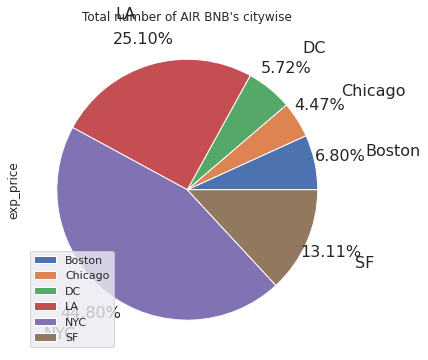

In [29]:
df1.groupby(['city']).sum().plot(kind='pie',y= 'exp_price',radius = 1,title=
 "Total number of AIR BNB's citywise",autopct='%1.2f%%',fontsize=16,figsize=(6, 6),pctdistance=1.2,labeldistance=1.4)

The Airbnb's listings in Newyork city is more expensive

In [30]:
df3 = df

Adding the amenities count column to the datafrane for checking whether the count has any impact on the price of Airbnb listings

In [31]:
df1['amenities_count'] = df1['amenities'].apply(lambda x : len(x.split(",")))

Bar plot of Price vs Amenities count

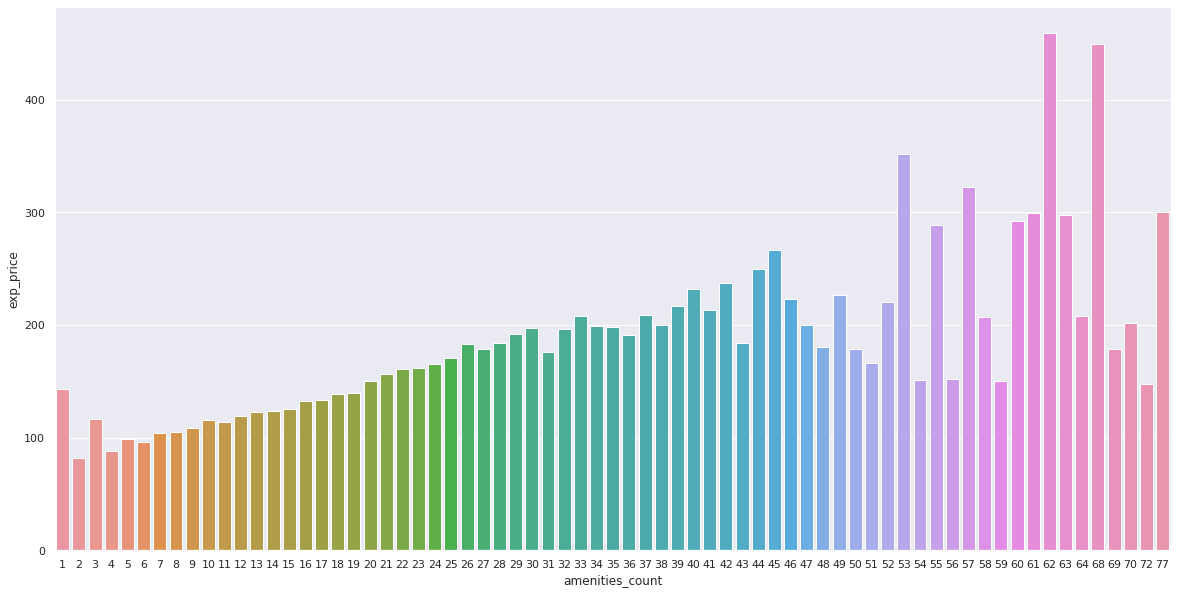

In [32]:
plt.figure(figsize=(20,10))
ax = sns.barplot(data=df1, y="exp_price", x="amenities_count",hue=None,ci=None)

Observation: There are some listings where the amenities are more and price is the less

### Does the price of the bed depends on the bedtype?

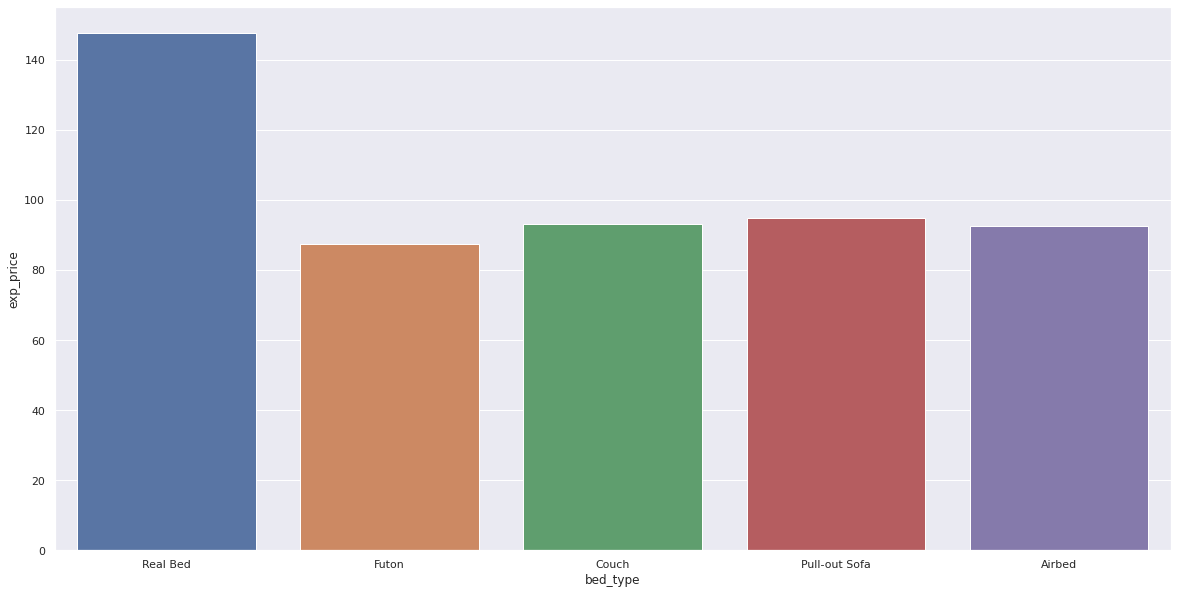

In [33]:
plt.figure(figsize=(20,10))
ax = sns.barplot(data=df1, y="exp_price", x="bed_type",hue=None,ci=None)

Observation: The price of the real bed is more when compared to the other bed types

# Is there any relation between the price and the number of persons it accommodates

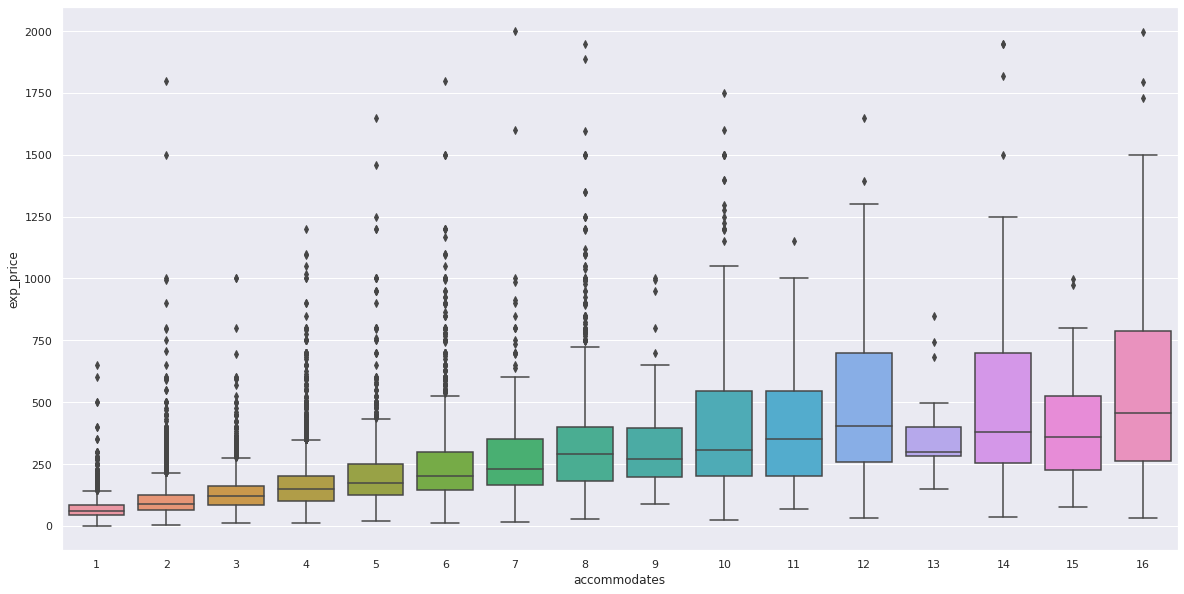

In [34]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(data=df1, y="exp_price", x="accommodates",hue=None)

Observation -  There is a strong correlation between them

# Does price depends on number of bedrooms provided in an Airbnb listing

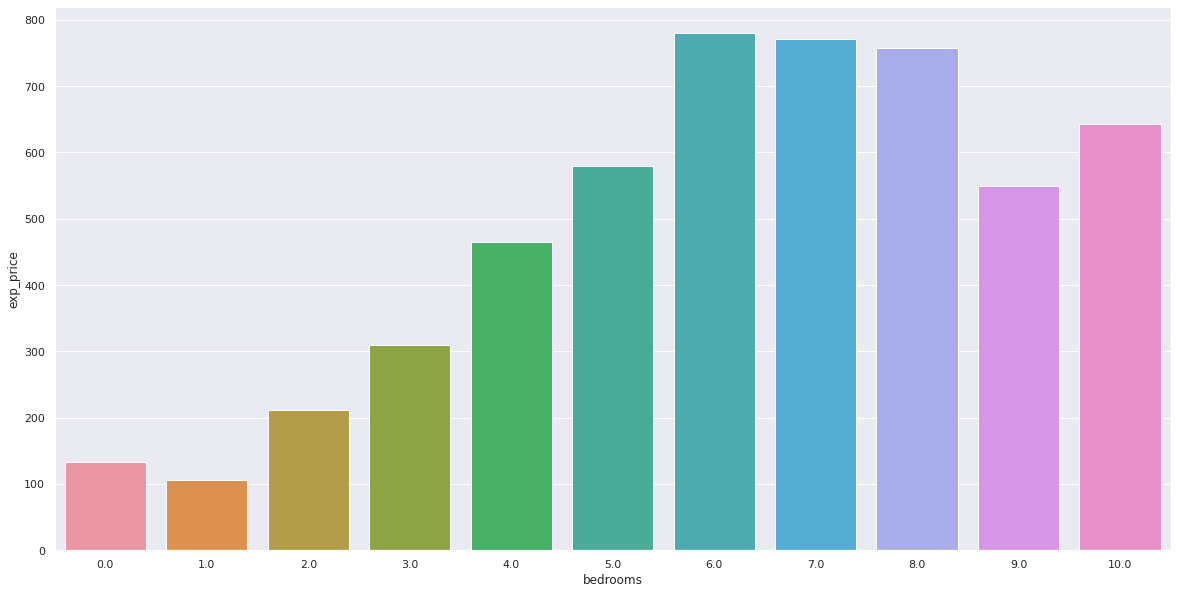

In [35]:
plt.figure(figsize=(20,10))
ax = sns.barplot(data=df1, y="exp_price", x="bedrooms",ci=None)

Observation - The price of the Airbnb listing is more when it have more bedrooms

# Does the price of the listing is more if it has more number of bathrooms  ?

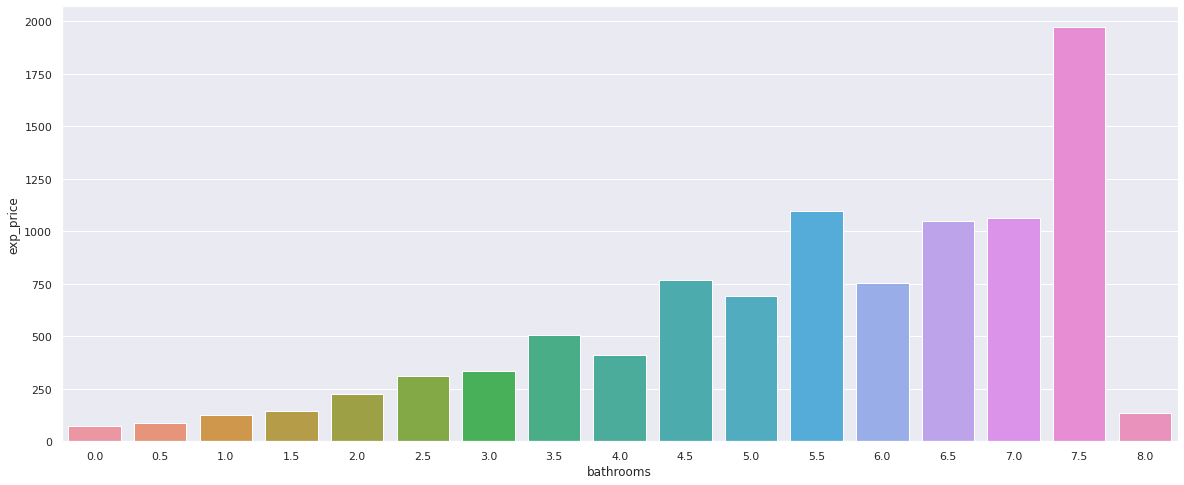

In [36]:
plt.figure(figsize = (20,8))
sns.barplot(x='bathrooms', y='exp_price', data=df1,ci=None);

Observation: the graph clearly shows the price of the listing increses with increase in the number of bathrooms

In [37]:
df1.head(2)

id  log_price property_type        room_type  \
0  6304928   5.129899     Apartment  Entire home/apt   
1  7919400   4.976734     Apartment  Entire home/apt   

                                           amenities  accommodates  bathrooms  \
0  {"Wireless Internet","Air conditioning",Kitche...             7        1.0   
1  {TV,"Cable TV","Wireless Internet","Air condit...             5        1.0   

   bed_type cancellation_policy  cleaning_fee  ...  \
0  Real Bed              strict          True  ...   
1  Real Bed            moderate          True  ...   

                                       name   neighbourhood number_of_reviews  \
0  Superb 3BR Apt Located Near Times Square  Hell's Kitchen                 6   
1                          The Garden Oasis          Harlem                10   

  review_scores_rating                                      thumbnail_url  \
0                 93.0  https://a0.muscache.com/im/pictures/348a55fe-4...   
1                 92.0  https://a0.muscache.com/im/pictures/6fae5362-9...   

  zipcode bedrooms beds exp_price  amenities_count  
0   10019      3.0  3.0     169.0               15  
1   10027      1.0  3.0     145.0               19  

[2 rows x 31 columns]

In [38]:
df4 = df3.withColumn("cleaning_fee",col("cleaning_fee").cast(StringType()))

Checking for correlation between the price and other variables

In [39]:
import six
for i in df4.columns:
    if not( isinstance(df4.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to log_price for ", i, df4.stat.corr('log_price',i))

Correlation to log_price for  log_price 1.0
Correlation to log_price for  accommodates 0.5821216346150896
Correlation to log_price for  bathrooms 0.3066494495230136
Correlation to log_price for  latitude 0.000853903764855051
Correlation to log_price for  longitude -0.05823807457798872
Correlation to log_price for  number_of_reviews -0.012968757197144054
Correlation to log_price for  review_scores_rating 0.07742280233346707
Correlation to log_price for  bedrooms 0.4808712214477055
Correlation to log_price for  beds 0.44713872342381755


The correlation values lies from +1 to -1, positive values represents the positive correlation and negative values represents the inverse relation.

In [40]:
df4.select([count(when(isnan(c), c)).alias(c) for c in df4.columns]).show()

+---+---------+-------------+---------+---------+------------+---------+--------+-------------------+------------+----+-----------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+--------+---------+----+-------------+-----------------+--------------------+-------------+-------+--------+----+
| id|log_price|property_type|room_type|amenities|accommodates|bathrooms|bed_type|cancellation_policy|cleaning_fee|city|description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|latitude|longitude|name|neighbourhood|number_of_reviews|review_scores_rating|thumbnail_url|zipcode|bedrooms|beds|
+---+---------+-------------+---------+---------+------------+---------+--------+-------------------+------------+----+-----------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+--------+---------+----+-------

Dropping the unnecessary columns from the data frame

In [41]:
df4 = df4.drop("id","description","first_review","thumbnail_url","name","last_review","zipcode")

In [42]:
(trainingData, testData) = df4.randomSplit([0.8, 0.2])


String Indexer and One Hot encoder to convert the variables into indexed variables

In [43]:
categoricalColumns = ['property_type','room_type','amenities','bed_type','cancellation_policy','cleaning_fee','city','host_has_profile_pic','host_identity_verified','host_response_rate','host_since',
'instant_bookable','neighbourhood']
stages = [] # stages in Pipeline
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    df4 = stringIndexer.fit(df4).transform(df4)
    df4 = encoder.fit(df4).transform(df4)
    

In [44]:
numeric_col = ['log_price','accommodates','bathrooms','latitude','longitude','number_of_reviews','review_scores_rating','bedrooms','beds']

In [45]:
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numeric_col
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
df4 = assembler.transform(df4)

Splitting the dataframe into training and test datasets

In [46]:
(trainingData, testData) = df4.randomSplit([0.8, 0.2])

### Linear Regression

In [47]:
lr = LinearRegression(featuresCol = 'features', labelCol='log_price', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(trainingData)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: (39899,[39890],[0.582972768358155])
Intercept: 1.9805406449147265


The R2 metric represents the proportion of variance in the dependent variable explained by the independent variable(s).


Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are.

In [48]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.275018
r2: 0.826088


In [49]:
lr_predictions = lr_model.transform(testData)
lr_predictions.select("prediction","log_price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+----------------+------------------+--------------------+
|      prediction|         log_price|            features|
+----------------+------------------+--------------------+
|3.55926016750414|2.7080502011022096|(39899,[10,17711,...|
|3.55926016750414|2.7080502011022096|(39899,[10,64,362...|
|3.55926016750414|2.7080502011022096|(39899,[13,15623,...|
|3.55926016750414|2.7080502011022096|(39899,[13,15626,...|
|3.55926016750414|2.7080502011022096|(39899,[13,288,36...|
+----------------+------------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.825953


In [50]:
test_result = lr_model.evaluate(testData)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 0.271973


In [51]:
predictions = lr_model.transform(testData)
predictions.select("prediction","log_price","features").show()

+------------------+------------------+--------------------+
|        prediction|         log_price|            features|
+------------------+------------------+--------------------+
|  3.55926016750414|2.7080502011022096|(39899,[10,17711,...|
|  3.55926016750414|2.7080502011022096|(39899,[10,64,362...|
|  3.55926016750414|2.7080502011022096|(39899,[13,15623,...|
|  3.55926016750414|2.7080502011022096|(39899,[13,15626,...|
|  3.55926016750414|2.7080502011022096|(39899,[13,288,36...|
|  3.55926016750414|2.7080502011022096|(39899,[13,17750,...|
|  3.55926016750414|2.7080502011022096|(39899,[13,64,362...|
|  3.55926016750414|2.7080502011022096|(39899,[13,64,362...|
|  3.55926016750414|2.7080502011022096|(39899,[1,1056,36...|
|3.5968843678374514| 2.772588722239781|(39899,[1,1154,36...|
| 3.697068387861046|2.9444389791664403|(39899,[0,6592,36...|
| 3.697068387861046|2.9444389791664403|(39899,[0,13030,3...|
| 3.726970981688367| 2.995732273553992|(39899,[0,31,1674...|
| 3.726970981688367| 2.9

The Root Mean Square error for the linear regressor to train the model to predic the price of Airbnb is 0.27

### Decision Tree Regressor

In [52]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'log_price')
dt_model = dt.fit(trainingData)
dt_predictions = dt_model.transform(testData)
dt_evaluator = RegressionEvaluator(
    labelCol="log_price", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.060637


In [54]:
dt_predictions.show(4)

+------------------+-------------+-----------+--------------------+------------+---------+--------+-------------------+------------+----+--------------------+----------------------+------------------+----------+----------------+------------------+-------------------+-------------+-----------------+--------------------+--------+----+------------------+---------------------+--------------+-----------------+--------------+--------------------+-------------+----------------+------------------------+---------------------------+-----------------+--------------------+---------+-------------+-------------------------+----------------------------+---------------------------+------------------------------+-----------------------+--------------------------+---------------+------------------+---------------------+------------------------+------------------+---------------------+--------------------+------------------+
|         log_price|property_type|  room_type|           amenities|accommodates|

The Root Mean squared Error for the decision Tree regressor is 0.06

### Gradient Boosting Regression

In [55]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'log_price', maxIter=10)
gbt_model = gbt.fit(trainingData)
gbt_predictions = gbt_model.transform(testData)
gbt_predictions.select('prediction', 'log_price', 'features').show(5)

+-----------------+------------------+--------------------+
|       prediction|         log_price|            features|
+-----------------+------------------+--------------------+
|2.932162556245678|2.7080502011022096|(39899,[10,17711,...|
|2.932162556245678|2.7080502011022096|(39899,[10,64,362...|
|2.932162556245678|2.7080502011022096|(39899,[13,15623,...|
|2.932162556245678|2.7080502011022096|(39899,[13,15626,...|
|2.932162556245678|2.7080502011022096|(39899,[13,288,36...|
+-----------------+------------------+--------------------+
only showing top 5 rows



In [56]:
gbt_evaluator = RegressionEvaluator(
    labelCol="log_price", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.0635137


In [57]:
print("R Squared (R2) on test data = %g" % gbt_evaluator.evaluate(gbt_predictions))

R Squared (R2) on test data = 0.0635137


The RMSE value for the GBT is 0.06

Final Observations: Decision tree regressor and Gradient Boosting regressor has almost same RMSE value and has better value when compared to the Linear regressor.

**References**:


https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a

https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a

https://www.kaggle.com/code/rjyoti/airbnb-data-analysis-and-price-prediction